In [21]:
import torch
print(torch.__version__)
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

2.4.0
CUDA is available! Training on GPU...
Files already downloaded and verified
Files already downloaded and verified


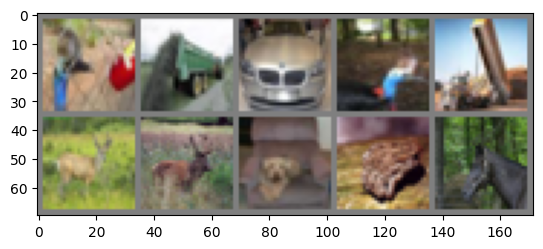

bird  truck car   bird  truck deer  deer  dog   frog  horse


In [22]:
import matplotlib.pyplot as plt


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images,nrow=5))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [23]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=32*32*3, output_dim=10):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
    x=torch.flatten(x, 1)
    x = self.linear(x)
    return x

model = LinearClassifier()
if train_on_gpu:
  model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Question 1: Train with corss-entropy. 
## The training of random guessing is at the end of this notebook

In [24]:

n_epochs = 25


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0


    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)



    train_loss = train_loss / len(trainloader.dataset)
    print(len(trainloader.dataset))

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} '.format(
        epoch, train_loss))

50000
Epoch: 1 	Training Loss: 1.881134 
50000
Epoch: 2 	Training Loss: 1.818100 
50000
Epoch: 3 	Training Loss: 1.795367 
50000
Epoch: 4 	Training Loss: 1.780531 
50000
Epoch: 5 	Training Loss: 1.772911 
50000
Epoch: 6 	Training Loss: 1.768987 
50000
Epoch: 7 	Training Loss: 1.762828 
50000
Epoch: 8 	Training Loss: 1.756032 
50000
Epoch: 9 	Training Loss: 1.747008 
50000
Epoch: 10 	Training Loss: 1.746981 
50000
Epoch: 11 	Training Loss: 1.745633 
50000
Epoch: 12 	Training Loss: 1.741160 
50000
Epoch: 13 	Training Loss: 1.742208 
50000
Epoch: 14 	Training Loss: 1.738814 
50000
Epoch: 15 	Training Loss: 1.733907 
50000
Epoch: 16 	Training Loss: 1.732576 
50000
Epoch: 17 	Training Loss: 1.731786 
50000
Epoch: 18 	Training Loss: 1.730683 
50000
Epoch: 19 	Training Loss: 1.726148 
50000
Epoch: 20 	Training Loss: 1.722308 
50000
Epoch: 21 	Training Loss: 1.722353 
50000
Epoch: 22 	Training Loss: 1.721631 
50000
Epoch: 23 	Training Loss: 1.721246 
50000
Epoch: 24 	Training Loss: 1.718840 
5

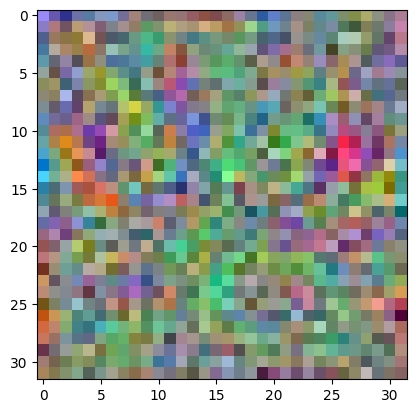

In [25]:
a=model.linear.weight[0] #inspect class 0 weight vector you have to repeat this for every class
b=a.reshape([3,32,32])
c=b.cpu().detach().numpy()

c[1]=(c[1]-c[1].min())/(c[1].max()-c[1].min()) # normalize the each color  channels
c[2]=(c[2]-c[2].min())/(c[2].max()-c[2].min())
c[0]=(c[0]-c[0].min())/(c[0].max()-c[0].min())

plt.imshow(np.transpose(c, (1, 2, 0)))



In [26]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.893898

Test Accuracy of plane: 38% (382/1000)
Test Accuracy of   car: 41% (415/1000)
Test Accuracy of  bird: 21% (210/1000)
Test Accuracy of   cat: 26% (263/1000)
Test Accuracy of  deer: 28% (286/1000)
Test Accuracy of   dog: 26% (263/1000)
Test Accuracy of  frog: 41% (418/1000)
Test Accuracy of horse: 34% (344/1000)
Test Accuracy of  ship: 57% (578/1000)
Test Accuracy of truck: 44% (449/1000)

Test Accuracy (Overall): 36% (3608/10000)


# Question 2: Visulize and interpret the results.

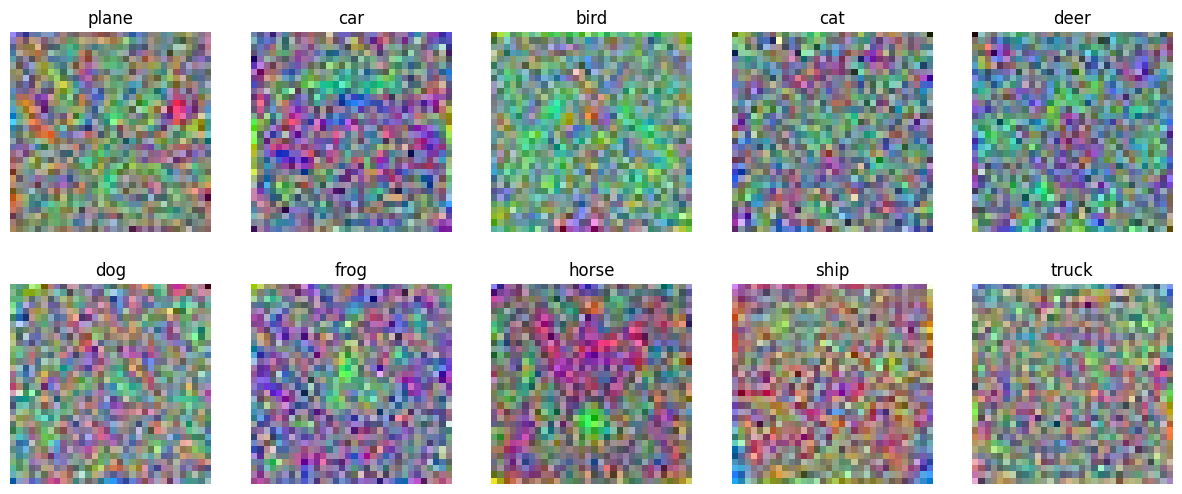

In [27]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    weight_vector = model.linear.weight[i]
    reshaped_weight = weight_vector.reshape(3, 32, 32).cpu().detach().numpy()
    
    # Normalize each color channel
    for j in range(3):
        reshaped_weight[j] = (reshaped_weight[j] - reshaped_weight[j].min()) / (reshaped_weight[j].max() - reshaped_weight[j].min())
    
    axes[i // 5, i % 5].imshow(np.transpose(reshaped_weight, (1, 2, 0)))
    axes[i // 5, i % 5].set_title(classes[i])
    axes[i // 5, i % 5].axis('off')

plt.show()

# Question 3: Plot two images at each class

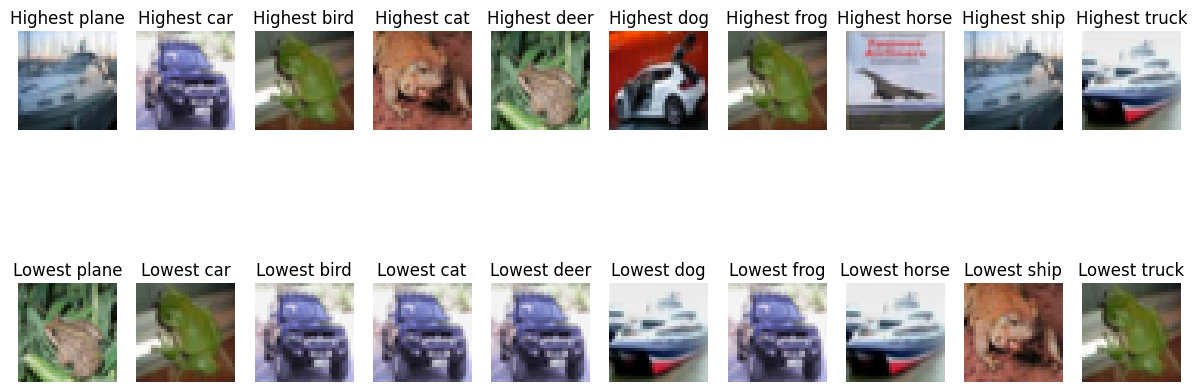

In [28]:
highest_score_images = []
lowest_score_images = []

for data, target in testloader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    # forward 
    output = model(data)
    for class_idx in range(len(classes)):
        class_scores = output[:, class_idx]
        
        highest_score_idx = torch.argmax(class_scores).item()
        lowest_score_idx = torch.argmin(class_scores).item()
        
        highest_score_images.append(data[highest_score_idx].cpu())
        lowest_score_images.append(data[lowest_score_idx].cpu())

fig, axes = plt.subplots(2, len(classes), figsize=(15, 6))

for i in range(len(classes)):
    # Plot the image with the highest score for the current class
    img_high = highest_score_images[i] / 2 + 0.5  # unnormalize
    npimg_high = img_high.numpy()
    axes[0, i].imshow(np.transpose(npimg_high, (1, 2, 0)))
    axes[0, i].set_title(f'Highest {classes[i]}')
    axes[0, i].axis('off')
    
    # Plot the image with the lowest score for the current class
    img_low = lowest_score_images[i] / 2 + 0.5  # unnormalize
    npimg_low = img_low.numpy()
    axes[1, i].imshow(np.transpose(npimg_low, (1, 2, 0)))
    axes[1, i].set_title(f'Lowest {classes[i]}')
    axes[1, i].axis('off')

plt.show()

# Question 4: Grayscale

In [29]:
# Convert images to grayscale
transform_grey = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the datasets
trainset_grey = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_grey)
trainloader_grey = torch.utils.data.DataLoader(trainset_grey, batch_size=batch_size, shuffle=True, num_workers=4)

testset_grey = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_grey)
testloader_grey = torch.utils.data.DataLoader(testset_grey, batch_size=batch_size, shuffle=False, num_workers=4)

# Define a new linear classifier for grayscale images
class LinearClassifierGrey(torch.nn.Module):
    def __init__(self, input_dim=32*32, output_dim=10):
        super(LinearClassifierGrey, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

# Initialize the model, criterion, and optimizer
model_grey = LinearClassifierGrey()
if train_on_gpu:
    model_grey.cuda()
criterion_grey = torch.nn.CrossEntropyLoss()
optimizer_grey = torch.optim.SGD(model_grey.parameters(), lr=0.001, momentum=0.9)

# Train the model with grayscale images
n_epochs = 25
for epoch in range(1, n_epochs + 1):
    train_loss_grey = 0.0
    model_grey.train()
    for data, target in trainloader_grey:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer_grey.zero_grad()
        output = model_grey(data)
        loss = criterion_grey(output, target)
        loss.backward()
        optimizer_grey.step()
        train_loss_grey += loss.item() * data.size(0)
    train_loss_grey = train_loss_grey / len(trainloader_grey.dataset)
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss_grey:.6f}')

# Evaluate the model with grayscale images
test_loss_grey = 0.0
class_correct_grey = list(0. for i in range(10))
class_total_grey = list(0. for i in range(10))

model_grey.eval()
for data, target in testloader_grey:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model_grey(data)
    loss = criterion_grey(output, target)
    test_loss_grey += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct_grey[label] += correct[i].item()
        class_total_grey[label] += 1

test_loss_grey = test_loss_grey / len(testloader_grey.dataset)
print(f'Test Loss (Grey): {test_loss_grey:.6f}')


Files already downloaded and verified


Files already downloaded and verified
Epoch: 1 	Training Loss: 2.066648
Epoch: 2 	Training Loss: 2.033951
Epoch: 3 	Training Loss: 2.023747
Epoch: 4 	Training Loss: 2.018852
Epoch: 5 	Training Loss: 2.014716
Epoch: 6 	Training Loss: 2.010894
Epoch: 7 	Training Loss: 2.008448
Epoch: 8 	Training Loss: 2.005635
Epoch: 9 	Training Loss: 2.003263
Epoch: 10 	Training Loss: 2.001493
Epoch: 11 	Training Loss: 2.000312
Epoch: 12 	Training Loss: 1.999307
Epoch: 13 	Training Loss: 1.996196
Epoch: 14 	Training Loss: 1.995396
Epoch: 15 	Training Loss: 1.995255
Epoch: 16 	Training Loss: 1.992830
Epoch: 17 	Training Loss: 1.993819
Epoch: 18 	Training Loss: 1.990534
Epoch: 19 	Training Loss: 1.991046
Epoch: 20 	Training Loss: 1.989176
Epoch: 21 	Training Loss: 1.986991
Epoch: 22 	Training Loss: 1.987502
Epoch: 23 	Training Loss: 1.987018
Epoch: 24 	Training Loss: 1.986000
Epoch: 25 	Training Loss: 1.985391
Test Loss (Grey): 2.084793


In [30]:

for i in range(10):
    if class_total_grey[i] > 0:
        print(f'Test Accuracy of {classes[i]} (Grey): {100 * class_correct_grey[i] / class_total_grey[i]:.2f}% ({int(np.sum(class_correct_grey[i]))}/{int(np.sum(class_total_grey[i]))})')
    else:
        print(f'Test Accuracy of {classes[i]} (Grey): N/A (no training examples)')

print(f'\nTest Accuracy (Overall) (Grey): {100. * np.sum(class_correct_grey) / np.sum(class_total_grey):.2f}% ({int(np.sum(class_correct_grey))}/{int(np.sum(class_total_grey))})')

Test Accuracy of plane (Grey): 41.80% (418/1000)
Test Accuracy of car (Grey): 34.10% (341/1000)
Test Accuracy of bird (Grey): 15.70% (157/1000)
Test Accuracy of cat (Grey): 17.20% (172/1000)
Test Accuracy of deer (Grey): 25.90% (259/1000)
Test Accuracy of dog (Grey): 25.30% (253/1000)
Test Accuracy of frog (Grey): 18.10% (181/1000)
Test Accuracy of horse (Grey): 27.50% (275/1000)
Test Accuracy of ship (Grey): 35.50% (355/1000)
Test Accuracy of truck (Grey): 42.70% (427/1000)

Test Accuracy (Overall) (Grey): 28.38% (2838/10000)


In [33]:
# retrain the model for color images
n_epochs = 25


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0


    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)



    train_loss = train_loss / len(trainloader.dataset)
    print(len(trainloader.dataset))

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} '.format(
        epoch, train_loss))

50000
Epoch: 1 	Training Loss: 1.854035 
50000
Epoch: 2 	Training Loss: 1.782643 
50000
Epoch: 3 	Training Loss: 1.764397 
50000
Epoch: 4 	Training Loss: 1.751787 
50000
Epoch: 5 	Training Loss: 1.743429 
50000
Epoch: 6 	Training Loss: 1.741096 
50000
Epoch: 7 	Training Loss: 1.733636 
50000
Epoch: 8 	Training Loss: 1.732309 
50000
Epoch: 9 	Training Loss: 1.722802 
50000
Epoch: 10 	Training Loss: 1.725436 
50000
Epoch: 11 	Training Loss: 1.721385 
50000
Epoch: 12 	Training Loss: 1.720245 
50000
Epoch: 13 	Training Loss: 1.715178 
50000
Epoch: 14 	Training Loss: 1.711421 
50000
Epoch: 15 	Training Loss: 1.714341 
50000
Epoch: 16 	Training Loss: 1.711038 
50000
Epoch: 17 	Training Loss: 1.709559 
50000
Epoch: 18 	Training Loss: 1.706934 
50000
Epoch: 19 	Training Loss: 1.705804 
50000
Epoch: 20 	Training Loss: 1.706459 
50000
Epoch: 21 	Training Loss: 1.700373 
50000
Epoch: 22 	Training Loss: 1.700624 
50000
Epoch: 23 	Training Loss: 1.700121 
50000
Epoch: 24 	Training Loss: 1.697206 
5

# Question 5: Apply rotation on testdata and then test

In [34]:
# Rotate images by 90 degrees
transform_rotate = transforms.Compose([
    transforms.RandomRotation((90, 90)), # Add the rotation here.
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the datasets again with the new transformation
testset_rotate = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_rotate)
testloader_rotate = torch.utils.data.DataLoader(testset_rotate, batch_size=batch_size, shuffle=False, num_workers=4)

# Evaluate the model with rotated images
test_loss_rotate = 0.0
class_correct_rotate = list(0. for i in range(10))
class_total_rotate = list(0. for i in range(10))

model.eval()
for data, target in testloader_rotate:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss_rotate += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct_rotate[label] += correct[i].item()
        class_total_rotate[label] += 1

test_loss_rotate = test_loss_rotate / len(testloader_rotate.dataset)
print(f'Test Loss (Rotated): {test_loss_rotate:.6f}')

for i in range(10):
    if class_total_rotate[i] > 0:
        print(f'Test Accuracy of {classes[i]} (Rotated): {100 * class_correct_rotate[i] / class_total_rotate[i]:.2f}% ({int(np.sum(class_correct_rotate[i]))}/{int(np.sum(class_total_rotate[i]))})')
    else:
        print(f'Test Accuracy of {classes[i]} (Rotated): N/A (no training examples)')

print(f'\nTest Accuracy (Overall) (Rotated): {100. * np.sum(class_correct_rotate) / np.sum(class_total_rotate):.2f}% ({int(np.sum(class_correct_rotate))}/{int(np.sum(class_total_rotate))})')

Files already downloaded and verified
Test Loss (Rotated): 2.596439
Test Accuracy of plane (Rotated): 26.40% (264/1000)
Test Accuracy of car (Rotated): 18.00% (180/1000)
Test Accuracy of bird (Rotated): 18.70% (187/1000)
Test Accuracy of cat (Rotated): 19.70% (197/1000)
Test Accuracy of deer (Rotated): 18.80% (188/1000)
Test Accuracy of dog (Rotated): 20.80% (208/1000)
Test Accuracy of frog (Rotated): 47.70% (477/1000)
Test Accuracy of horse (Rotated): 7.70% (77/1000)
Test Accuracy of ship (Rotated): 24.90% (249/1000)
Test Accuracy of truck (Rotated): 6.20% (62/1000)

Test Accuracy (Overall) (Rotated): 20.89% (2089/10000)


# Testing for Random Guessing

In [32]:
n_epochs = 25

for epoch in range(1, n_epochs+1):
  # keep track of training and validation loss
  train_loss = 0.0

  model.train()
  for data, target in trainloader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()
    output = model(data)
    
    random_predictions = torch.randint(0, 10, target.shape, device=target.device)
    loss = criterion(output, random_predictions)
    
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item() * data.size(0)

  train_loss = train_loss / len(trainloader.dataset)

  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in testloader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
  
    output = model(data)

    random_predictions = torch.randint(0, 10, target.shape, device=target.device)
    loss = criterion(output, random_predictions)

    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Epoch: 1 	Training Loss: 2.661262
Epoch: 2 	Training Loss: 2.566844
Epoch: 3 	Training Loss: 2.542099
Epoch: 4 	Training Loss: 2.534879
Epoch: 5 	Training Loss: 2.530661
Epoch: 6 	Training Loss: 2.519006
Epoch: 7 	Training Loss: 2.520631
Epoch: 8 	Training Loss: 2.514699
Epoch: 9 	Training Loss: 2.509772
Epoch: 10 	Training Loss: 2.509242
Epoch: 11 	Training Loss: 2.502603
Epoch: 12 	Training Loss: 2.504613
Epoch: 13 	Training Loss: 2.503744
Epoch: 14 	Training Loss: 2.504104
Epoch: 15 	Training Loss: 2.505088
Epoch: 16 	Training Loss: 2.506411
Epoch: 17 	Training Loss: 2.501325
Epoch: 18 	Training Loss: 2.500614
Epoch: 19 	Training Loss: 2.501226
Epoch: 20 	Training Loss: 2.500257
Epoch: 21 	Training Loss: 2.503545
Epoch: 22 	Training Loss: 2.498681
Epoch: 23 	Training Loss: 2.500780
Epoch: 24 	Training Loss: 2.499731
Epoch: 25 	Training Loss: 2.500963
Test Loss: 2.560516

Test Accuracy of plane: 14% (146/1000)
Test Accuracy of   car: 21% (216/1000)
Test Accuracy of  bird:  5% (57/100

# Add rotation on both training dataset and testing dataset

In [ ]:
import torchvision
import torchvision.transforms as transforms
# Rotate images by 90 degrees
transform_rotate = transforms.Compose([
    transforms.RandomRotation((90, 90)), # Add the rotation here.
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_rotate)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_rotate)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=32*32*3, output_dim=10):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
    x=torch.flatten(x, 1)
    x = self.linear(x)
    return x

model = LinearClassifier()
if train_on_gpu:
  model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)





n_epochs = 25


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0


    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)



    train_loss = train_loss / len(trainloader.dataset)
    print(len(trainloader.dataset))

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} '.format(
        epoch, train_loss))


# Load the datasets again with the new transformation
testset_rotate = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_rotate)
testloader_rotate = torch.utils.data.DataLoader(testset_rotate, batch_size=batch_size, shuffle=False, num_workers=4)

# Evaluate the model with rotated images
test_loss_rotate = 0.0
class_correct_rotate = list(0. for i in range(10))
class_total_rotate = list(0. for i in range(10))

model.eval()
for data, target in testloader_rotate:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss_rotate += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct_rotate[label] += correct[i].item()
        class_total_rotate[label] += 1

test_loss_rotate = test_loss_rotate / len(testloader_rotate.dataset)
print(f'Test Loss (Rotated): {test_loss_rotate:.6f}')

for i in range(10):
    if class_total_rotate[i] > 0:
        print(f'Test Accuracy of {classes[i]} (Rotated): {100 * class_correct_rotate[i] / class_total_rotate[i]:.2f}% ({int(np.sum(class_correct_rotate[i]))}/{int(np.sum(class_total_rotate[i]))})')
    else:
        print(f'Test Accuracy of {classes[i]} (Rotated): N/A (no training examples)')

print(f'\nTest Accuracy (Overall) (Rotated): {100. * np.sum(class_correct_rotate) / np.sum(class_total_rotate):.2f}% ({int(np.sum(class_correct_rotate))}/{int(np.sum(class_total_rotate))})')

Files already downloaded and verified
Files already downloaded and verified
50000
Epoch: 1 	Training Loss: 1.882139 
50000
Epoch: 2 	Training Loss: 1.817656 
50000
Epoch: 3 	Training Loss: 1.799355 
50000
Epoch: 4 	Training Loss: 1.787269 
50000
Epoch: 5 	Training Loss: 1.774861 
50000
Epoch: 6 	Training Loss: 1.767215 
50000
Epoch: 7 	Training Loss: 1.763673 
50000
Epoch: 8 	Training Loss: 1.757276 
50000
Epoch: 9 	Training Loss: 1.751029 
50000
Epoch: 10 	Training Loss: 1.748429 
50000
Epoch: 11 	Training Loss: 1.745839 
50000
Epoch: 12 	Training Loss: 1.741737 
50000
Epoch: 13 	Training Loss: 1.741060 
50000
Epoch: 14 	Training Loss: 1.735704 
50000
Epoch: 15 	Training Loss: 1.734891 
50000
Epoch: 16 	Training Loss: 1.731629 
50000
Epoch: 17 	Training Loss: 1.732828 
50000
Epoch: 18 	Training Loss: 1.729619 
50000
Epoch: 19 	Training Loss: 1.724428 
50000
Epoch: 20 	Training Loss: 1.725101 
50000
Epoch: 21 	Training Loss: 1.724296 
50000
Epoch: 22 	Training Loss: 1.721850 
50000
Epo